In [2]:
%reload_ext autoreload
%autoreload 2

import sys
import pandas as pd
import time
import timeit
sys.path.insert(0, './Moduulit')
pd.options.mode.chained_assignment = None

from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets


# Importtaus tässä muodossa
from database_connection import database_query
from outliers import find_outliers, draw_histogram
from LOF import *
from clean_dataframe import clean_dataframe
from clean_velocities import *
from draw_nodes import *
from draw_node_amount import *
from write_df_to_database import write_df_to_mariadb
from xy_diskretisointi import xy_to_grid
from reittien_erottelu import *
from isolation_forest import *
from sisään_uloskäynnit import *
from horrostila import *
from widgets import *
from plot_lapimenoajat import *
from klusterointi import *

'''def timing():
    start_time = timeit.default_timer()
    #start_time = time.time()
    #return lambda x: print("{} {:.3f}s".format(x, time.time() - start_time))
    y = '{:.10f}s #'.format(timeit.default_timer() - start_time)
    return lambda x: print(f"\n#{len(y+x)*'='}#\n# {x}{y}\n#{len(y+x)*'='}#\n")
t = timing()
t("Execution time: ")'''
# tai from ... import *

'def timing():\n    start_time = timeit.default_timer()\n    #start_time = time.time()\n    #return lambda x: print("{} {:.3f}s".format(x, time.time() - start_time))\n    y = \'{:.10f}s #\'.format(timeit.default_timer() - start_time)\n    return lambda x: print(f"\n#{len(y+x)*\'=\'}#\n# {x}{y}\n#{len(y+x)*\'=\'}#\n")\nt = timing()\nt("Execution time: ")'

In [2]:
@interact_manual

def dataoptions(
    
    nodes = widgets.SelectMultiple(options= nodeIds,value=['All'],description='Node_id(s): ', disabled=False, layout=Layout(margin='0px 0px 40px 200px')),

    start_date=widgets.DatePicker(value=pd.to_datetime('2020-06-24'),description='Starting Date', layout=Layout(margin='0px 0px 0px 0px')),                      
    end_date=widgets.DatePicker(value=pd.to_datetime('2020-11-01 23:00:00'),description='Ending Date', layout=Layout(margin='-30px 0px 0px 400px')),
                           
    tuntivalitsin=widgets.SelectionRangeSlider(options=OptHours,index=[0,14],
    description='Tunnit',disabled=False,value=[8,22], layout=Layout(margin='20px 0px 0px 0px')),

   ):
   
    
    def getdata():
        
        global df
        import mysql.connector
        mydb = mysql.connector.connect(
        host="172.28.200.50",
       user="root",
        port=3306,
      passwd="insert-password-here",
        database="iiwari_org")
        
        mycursor = mydb.cursor(dictionary=True)
        
        # Paivmaarat string formaattiin
        start_date_string = "'{}'".format(str(start_date))
        end_date_string = "'{}'".format(str(end_date))
        
        
        # Sql kysely vaihtoehdot jos valittu 'All'
        if nodes[0] == 'All':
            mycursor.execute("SELECT * FROM CleanSensorData WHERE timestamp >= {} and timestamp < {}".format(start_date_string, end_date_string))
            
        # Jos vain 1 node valittu
        elif len(nodes) == 1:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id={} and timestamp >= {} and timestamp < {}".format(nodes[0], start_date_string, end_date_string))
        
        # Monta nodea valittuna
        else:
            mycursor.execute("SELECT * FROM CleanSensorData WHERE node_id IN {} and timestamp >= {} and timestamp < {}".format(nodes, start_date_string, end_date_string))
            
        df = pd.DataFrame(mycursor.fetchall())
        
        # Palauttaa virheilmoituksen jos dataframe on tyhja
        if len(df) == 0:
            return print("Error 01: Empty Dataset ")
        
        
        # Timestamp datetime muotoon
        df['timestamp'] = df['timestamp'].astype(str)
        df['timestamp'] = df['timestamp'].str.slice(2, -2)
        df['timestamp'] = df['timestamp'].astype('datetime64[ns]')
        
        # Sorttaa tunnit                   
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') >= tuntivalitsin[0]]
        df = df.loc[df.timestamp.dt.strftime('%-H').astype('int32') <= tuntivalitsin[1]]
        
        return df
    
    df = getdata()
   
    # Haetaan valittu kuvaaja, widgeteiltä saatujen arvojen perusteella #
    return df

interactive(children=(SelectMultiple(description='Node_id(s): ', index=(0,), layout=Layout(margin='0px 0px 40p…

# Database query

In [39]:
%%time
df = database_query("SELECT * FROM SensorData")
df_len = len(df)
df

CPU times: user 3min 35s, sys: 22.8 s, total: 3min 58s
Wall time: 3min 58s


,node_id,timestamp,x,y,z,q
0,b'-2393099149039893833',b'2020-06-24 12:20:08.533016+00:00',2762,-257,100,0
1,b'-2393099149039893833',b'2020-06-24 12:20:08.620015+00:00',2870,-344,100,0
2,b'-2393099149039893833',b'2020-06-24 12:20:09.622827+00:00',2916,-344,100,0
3,b'-2393099149039893833',b'2020-06-24 12:20:09.622846+00:00',2894,-254,100,0
4,b'-2393099149039893833',b'2020-06-24 12:20:10.116102+00:00',2888,-188,100,0
...,...,...,...,...,...,...
13890901,b'4996252679627069957',b'2020-06-01 03:00:05.469336+00:00',635,1064,0,0
13890902,b'4996252679627069957',b'2020-06-01 03:00:06.47926+00:00',681,760,0,0
13890903,b'4996252679627069957',b'2020-06-01 03:00:08.507118+00:00',622,991,0,0
13890904,b'4996252679627069957',b'2020-06-01 03:00:09.547553+00:00',644,1066,0,0


# Check what the different nodes look like

Nodes:  32


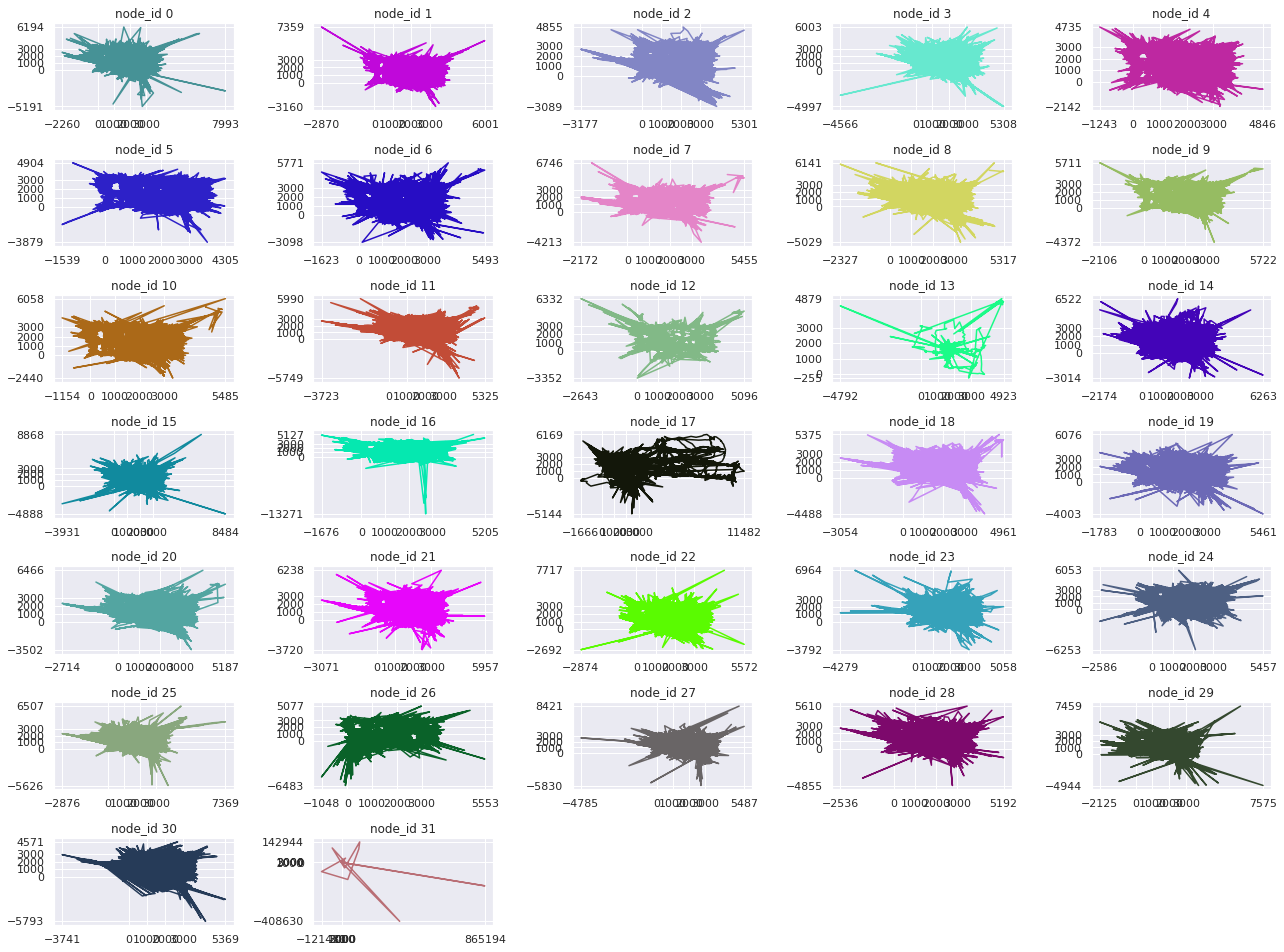

In [103]:
draw_nodes(df, 'node_id')

# Histogram of x and y coordinates

x mean:  1721.8087923854644
y mean:  680.035106133466
x std:  1031.8899924277641
y std:  1088.7371382819924


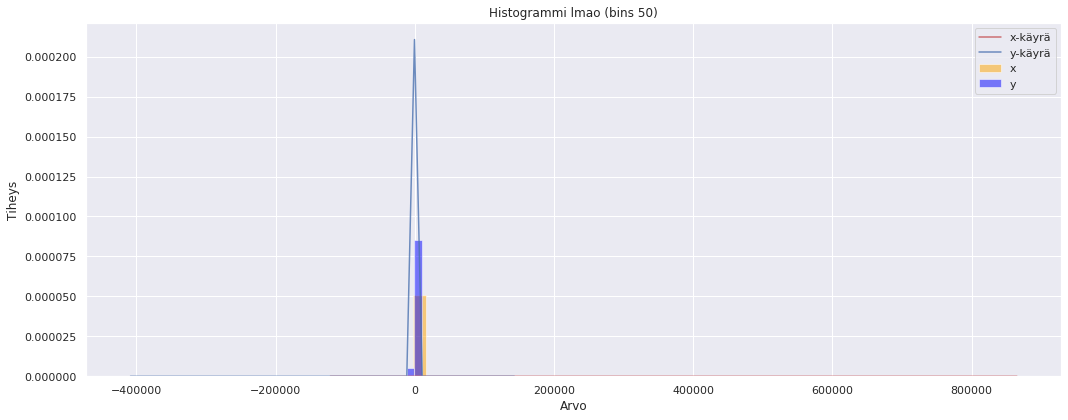

CPU times: user 2.48 s, sys: 108 ms, total: 2.59 s
Wall time: 1.18 s


In [40]:
%%time
draw_histogram(df['x'], df['y'], 50)

# Find outliers using z_score

Number of missing variables in table
 node_id      0
timestamp    0
x            0
y            0
z            0
q            0
dtype: int64
------------------------------
Unique values in columns

uniques in node_id: 32
uniques in timestamp: 13890888
uniques in x: 10532
uniques in y: 7899
uniques in z: 3
uniques in q: 1
------------------------------
Checking z and q columns

uniques in z [100 400   0]
uniques in q [0]
------------------------------
Number of nodes: 32
------------------------------
Outliers

Data with outliers:  13890906
Ouliers removed:     376791
Data after:          13514115
Percent removed:    2.71 %
Percent remaining:  97.29 %
------------------------------


./Moduulit/outliers.py:70: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig("outliers-in-data.png")


CPU times: user 42.1 s, sys: 1.26 s, total: 43.3 s
Wall time: 43.3 s


/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


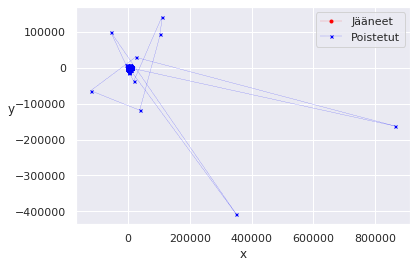

In [41]:
%%time
df1 = find_outliers(df)
df_len_outliers = len(df1)

Koko datasetissä (13 890 906)
- Data with outliers: 13 890 906
- Ouliers removed:    376 791
- Data after:         13 514 115

# Cleaning Node_id, timestamp, q, z columns

In [42]:
df1 = clean_dataframe(df1)
df_len_clean = len(df1)
df1

[15  7  8  9 10 11 12 13 16 17 18 19 20 14  6 21  5 22 23  0  1  2  3  4]
------------------------------
Filtering out after-hours

Data before filtering:  13514115
Deleted nodes before 8:00:  1511622
Deleted nodes after 21:00:  304827
Deleted after-hours nodes:  25211781
------------------------------
Bad nodes: [13, 14, 18, 27, 32]

Amount of bad nodes 1885771
Data after deleting bad nodes:  9725303
------------------------------


,node_id,timestamp,x,y,dayofweek,current_hour
0,1,2020-06-24 15:20:08.533,2762,-257,2,8
1,1,2020-06-24 15:20:08.620,2870,-344,2,8
2,1,2020-06-24 15:20:09.623,2916,-344,2,8
3,1,2020-06-24 15:20:09.623,2894,-254,2,8
4,1,2020-06-24 15:20:10.116,2888,-188,2,8
...,...,...,...,...,...,...
10837392,31,2020-09-30 12:24:13.062,2711,-311,2,5
10837393,31,2020-09-30 12:24:50.062,2718,-318,2,5
10837394,31,2020-09-30 12:25:36.062,2721,-324,2,5
10837395,31,2020-09-30 12:26:03.062,2719,-323,2,5


# LocalOutlierFactor

Starting...
Chunk size:  9711.058
Printing the plot...##################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################################

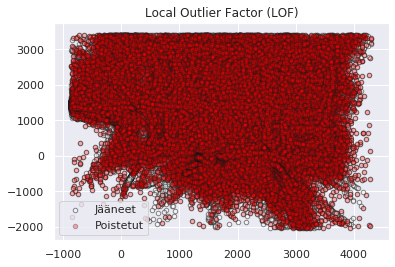

Alkuperäinen data: 9711058
Dataa jäljellä: 9696462
Poistetut outlierit:  14596


In [104]:
df2, outlierit = LOF(df1, 10, 10)
# Draw the deleted and kept points
draw_LOF(df1, outlierit)

# Do some stuff to calculate the amount dropped.
df3 = df1[~df1.isin(df2)].dropna()
print("Alkuperäinen data:",len(df1))
print("Dataa jäljellä:",len(df3))
print("Poistetut outlierit: ",len(df1) - len(df3))
df1 = df3
df_len_LOF = len(df1)

# How much nodes have been in use

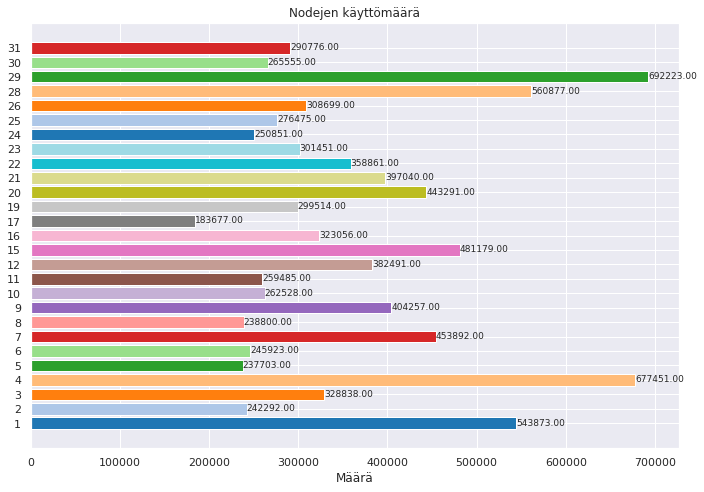

In [45]:
draw_node_amount(df1, 'node_id')

# Tehdään uuten tiedostoon Isolation Forestilla putsatut nodet

In [10]:
df1['node_id'].unique()

array([1])

In [11]:
from collections import Counter

dftest = df1.copy()
# Alustetaan Counter
_count = Counter()
_count.update(dftest['node_id'])

cart_name = []
cart_amount = []

for i in _count:
    cart_name.append(i)
    cart_amount.append(_count[i])
print(cart_name, cart_amount)

[1] [9628]


In [49]:
x_temp = len(df1.loc[df1['node_id']==1][['x', 'y']])
print("node:",x_temp)

node: 545350


In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.ensemble import IsolationForest


def isolation_forest(df, random_state, contamination):
    df_original = df.copy()
    outliers=[]
    outlier_len=[]
    # x ja y arvot talteen
    #x_temp = df.loc[df['node_id']==i][['x', 'y']]
    x_temp = df[['x', 'y']]

    # Init minmaxscaler + fit+transform
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x_temp)

    # Normalisoidut arvot uuteen dataframeen
    xy_normalized = pd.DataFrame(x_scaled)
    xy_normalized = xy_normalized.rename(columns={0: 'x', 1: 'y'})

    # Isolationforest annetuin parametrein + fit
    clf = IsolationForest(max_samples=len(x_scaled),random_state=random_state, contamination=contamination) 
    clf.fit(xy_normalized)

    # Outlier detect
    if_scores = clf.decision_function(xy_normalized)
    if_anomalies=clf.predict(xy_normalized)
    outlier_len.append(clf.predict(xy_normalized))
    if_anomalies=pd.Series(if_anomalies).replace([-1,1],[1,0])
    if_anomalies=xy_normalized[if_anomalies==1]
        
    outliers.append(x_temp.iloc[if_anomalies.index.values])

    # Drop outliers from df + reset index
    x_temp = x_temp.drop(x_temp.index[if_anomalies.index.values])

    # Grab that sweet timestamp
    df = df.loc[x_temp.index]
    df = df_temp.reset_index(drop=True)
    #Plot results
    #plt.gca().invert_yaxis()
        
    return df, outliers
    
    print(f"{'-'*30}")
    print('Node datapoints before:', len(df_original))
    print('Node datapoints after:', len(df))
    print('Total outliers detected:', len(outlier_len))

    total_data = len(df_original)
    total_missing = len(outlier_len)
    percentage = (total_missing/total_data) * 100
    percentage_remain = (1 - (total_missing/total_data)) * 100
    print("\nPercent removed:   ",round(percentage, 2),'%')
    print("Percent remaining: ",round(percentage_remain, 2),'%')
    print(f"{'-'*30}")

def plot_isolation_forest(df, outliers):
    """[Plottaa jokaisen kauppareissun peräkkäin]

     Args:
         df_reitit ([DataFrame]): [Sisältää erotellut kauppareitit]
         grid_size ([int]): [Gridin koko on määritelty tämän mukaan.]
     """
    node = df.node_id.unique()
    node_len = max(df.node_id.unique())

    #c = cm.flag(np.linspace(0, 1, ajot_len))
    plt.figure(figsize=(20,15))


    for i in range(node_len):
        plt.subplot((node_len/5)+1,4,i+1)
        plt.scatter(df['x'],df['y'],edgecolor='black',s=15, label="Jääneet")
        plt.scatter(outliers['x'],outliers['y'],edgecolor='red',s=15, label="Poistetut")
        plt.ylabel("x")
        plt.ylabel("y", rotation='0')
        plt.title(f"Node {i+1}")
        #plt.xlim(0, 40)
        #plt.ylim=(0, 40)
        #plt.axis('off')

    plt.show()

In [72]:
%%time
'''for i in df1.node_id.unique():
    df2, deleted = isolation_forest(df1, 0, .003, i)
    print(f'Node {i} valmis!')'''
df2, deleted = isolation_forest(df1, 0, .003)

'''
    if i == 0:
        df1.to_csv('./temp_data.csv', index=False)
    else:
        df1.to_csv('./temp_data.csv',mode='a', header=False, index=False)
        
df2 = pd.read_csv('./temp_data.csv')
import os
os.remove("./temp_data.csv")
df2.head()'''
plot_isolation_forest(df2, deleted)
df_len_isolation = len(df2)

NameError: name 'df_temp' is not defined

# Adding xy_grid values to dataframe (50x50)

In [105]:
%%time
grid_size = 40
df1 = xy_to_grid(df1, df1.x, df1.y, grid_size)
print(df1)

          node_id               timestamp       x       y  dayofweek  \
28              1 2020-06-24 15:20:56.088  3560.0  2009.0          2   
29              1 2020-06-24 15:20:59.798  3559.0  2250.0          2   
30              1 2020-06-24 15:21:11.232  3152.0  2963.0          2   
31              1 2020-06-24 15:21:12.231  3013.0  2793.0          2   
32              1 2020-06-24 15:21:13.512  2923.0  2740.0          2   
...           ...                     ...     ...     ...        ...   
10837392       31 2020-09-30 12:24:13.062  2711.0  -311.0          2   
10837393       31 2020-09-30 12:24:50.062  2718.0  -318.0          2   
10837394       31 2020-09-30 12:25:36.062  2721.0  -324.0          2   
10837395       31 2020-09-30 12:26:03.062  2719.0  -323.0          2   
10837396       31 2020-09-30 14:17:55.062  2719.0  -323.0          2   

          current_hour  x_grid  y_grid  grid_id  
28                   8      34      29     1194  
29                   8      34     

# Poistetaan liiat nopeudet

In [ ]:
%%time
# Otetaan kopio taulusta piirtämistä varten
dftest = df1.copy()
# Laskee x:n ja y:n oudot nopeudet
uusi_df, speeds, distances = velocity.column_vel(dftest, 'x', 'y')
df_len_velocities = len(uusi_df)
# Piirtää kuvan näistä
velocity.draw_vel(df1, uusi_df, 'x', 'y')

In [ ]:
x_cut = pd.cut(uusi_df['distance_m'], 40,labels=False)
# Laitetaan saadut arvot dataframeen
uusi_df['distance_grid'] = x_cut.values
# Laitetaan arvot dataframeen, xygridiID = y * gridsize +x
#uusi_df['test'] = uusi_df['test'] * 40 + uusi_df['test']
uusi_df

# Find and draw exits

In [ ]:
%%time
df1 = uusi_df.copy()
in_x, in_y = sisään(df1, 'x_grid', 'y_grid')
out_x, out_y = ulos(df1, 'x_grid', 'y_grid')

draw_exits(df1, in_x, in_y, out_x, out_y, 'x_grid', 'y_grid')

In [ ]:
%%time
# Muokataan sisäänkäynnin ja kassojen sijainnit ID-muotoon.
grid_size = 40
in_ID = xy_to_ID(in_x,in_y, grid_size)
out_ID = xy_to_ID(out_x,out_y, grid_size)

# Voidaan tarkistaa sijaintien oikeellisuus
'''sns.scatterplot(x="x_grid", y="y_grid", data = df1)
sns.scatterplot(x=in_x, y=in_y)
sns.scatterplot(x=out_x, y=out_y)
hmax= sns.kdeplot(df1.x_grid, df1.y_grid, cmap="afmhot", shade=True, alpha = 0.7)
hmax.collections[3].set_alpha(0)'''
plt.scatter(df1['x_grid'], df1['y_grid'], color='steelblue', s=5)#np.random.random(3)
plt.scatter(in_x, in_y, color='darkorange', marker='s', s=10, label="Start")
plt.scatter(out_x, out_y, color='lime', marker='s', s=10, label="Exit")
plt.title("Sisään- ja uloskäynnit")
plt.legend()

plt.show()

### Erotetaan kauppareissut toisistaan

In [63]:
%%time
# Haetaan uniikit id:t
u_in_ID = in_ID.unique()
u_out_ID = out_ID.unique()

reitit = erottele_reitit(df1, u_in_ID, u_out_ID)

reitit = poista_lyhyet_reitit(reitit, grid_size)
df_reitit = reitit_dataframeksi(reitit)

Poistetut liian lyhyet reitit: 4
Hyvät reitit: 111
------------------------------
CPU times: user 1.02 s, sys: 0 ns, total: 1.02 s
Wall time: 1.01 s


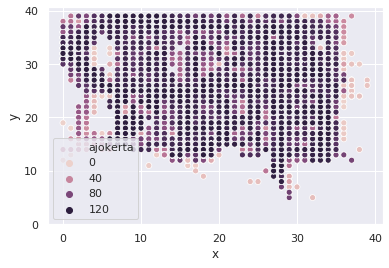

CPU times: user 4.23 s, sys: 108 ms, total: 4.34 s
Wall time: 2.97 s


In [64]:
%%time
# Plotataan kaikki erotellut kauppareissut yhdessä
plot_all_routes(df_reitit, grid_size)

In [ ]:
# creating the dataset 
data = {'Original':df_len, 'Outliers':df_len_outliers, 'Clean':df_len_clean, 'LOF':df_len_LOF, 'Velocities':df_len_velocities} 
section = list(data.keys()) 
values = list(data.values()) 
   
fig = plt.figure(figsize = (8, 4)) 
  
N = 5
cmap = cm.jet(np.linspace(0, 1, N))

plt.bar(section, values, color=cmap,  
        width = 0.4) 
  
plt.xlabel("Siivous menetelmä") 
plt.ylabel("Pisteiden määrä") 
plt.title("Datan määrä eri siivouksien jälkeen") 
for i in range(len(values)):
    plt.annotate(str(values[i]), xy=(section[i],values[i]), ha='center', va='bottom')

plt.show()

# Write cleaned and diskretized dataframe to mariadb database

In [10]:
%%time
write_df_to_mariadb(uusi_df, 'Testi')

Existing table found. Prepairing to Drop Table named Testi...


Continue? yes/no:  


Invalid input. Try again


Continue? yes/no:  no


Aborting...
CPU times: user 6.09 ms, sys: 0 ns, total: 6.09 ms
Wall time: 2.22 s


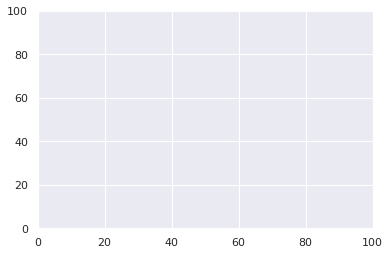

In [198]:
import matplotlib
#matplotlib.use('Qt5Agg') #use Qt5 as backend, comment this line for default backend

from matplotlib import pyplot as plt
from matplotlib import animation

fig = plt.figure()

ax = plt.axes(xlim=(0, 100), ylim=(0, 100))

#lines = [plt.plot([], [])[0] for _ in range(N)] #lines to animate
lines = ax.plot([], [], marker="o", markersize=5, color=np.random.random(3), markerfacecolor=np.random.random(3))

plt.show()
def init():
    #init lines
    line.set_data([], [])

    return (lines) #return everything that must be updated

def animate(i):
    #animate lines
    #line.set_data([0, 2], [10 * j,i])
    for j in range(ajot_len):
        x = df_reitit[df_reitit["ajokerta"] == j]['x']
        y = df_reitit[df_reitit["ajokerta"] == j]['y']
        line.set_data(x[:i], y[:i])

    return (lines) #return everything that must be updated


anim = animation.FuncAnimation(fig, animate, init_func=init,frames=100, interval=20, blit=True)

anim.save('kakka.gif', writer='pillow', fps=60)
plt.show()

In [93]:
df1

,node_id,timestamp,x,y,dayofweek,current_hour,x_grid,y_grid,grid_id,velocity_kmh,distance_m,distance_grid,IN,OUT,fo_IN,fo_OUT
102,1,2020-06-24 15:23:26.072,386.0,148.0,2,8,5,15,605,0.577171,26.005,39.0,False,False,NaN,NaN
103,1,2020-06-24 15:23:26.165,395.0,164.0,2,8,5,15,605,0.749846,1.214,1.0,False,False,NaN,NaN
104,1,2020-06-24 15:23:26.629,525.0,176.0,2,8,7,15,607,0.241103,3.374,5.0,False,False,NaN,NaN
107,1,2020-06-24 15:23:27.837,480.0,50.0,2,8,6,14,566,0.493265,1.355,2.0,False,False,NaN,NaN
108,1,2020-06-24 15:23:28.792,558.0,46.0,2,8,7,14,567,1.487274,3.214,4.0,False,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94789,1,2020-07-18 12:53:05.795,2952.0,1060.0,5,5,29,22,909,NaN,NaN,NaN,False,False,False,False
94790,1,2020-07-18 12:53:05.795,2962.0,1046.0,5,5,29,22,909,NaN,NaN,NaN,False,False,False,False
94791,1,2020-07-18 12:53:06.795,2969.0,1040.0,5,5,29,22,909,NaN,NaN,NaN,False,False,False,False
94792,1,2020-07-18 12:53:07.795,2982.0,1037.0,5,5,29,22,909,NaN,NaN,NaN,False,False,False,False


In [2]:
%%time
df_reitit = database_query("SELECT * FROM hyvatReititDB LIMIT 10000")
df_reitit

CPU times: user 219 ms, sys: 16.3 ms, total: 236 ms
Wall time: 243 ms


,ajokerta,node_id,timestamp,x,y,grid_id,kesto,dayofweek,current_hour
0,1,1,2020-06-24 15:20:12,22,11,352,64858.412,2,8
1,1,1,2020-06-24 15:20:13,22,11,352,64858.412,2,8
2,1,1,2020-06-24 15:20:14,22,11,352,64858.412,2,8
3,1,1,2020-06-24 15:20:21,26,12,386,64858.412,2,8
4,1,1,2020-06-24 15:20:22,25,12,385,64858.412,2,8
...,...,...,...,...,...,...,...,...,...
9995,32,1,2020-07-05 13:46:01,25,13,415,1333.999,6,4
9996,32,1,2020-07-05 13:46:02,25,13,415,1333.999,6,4
9997,32,1,2020-07-05 13:46:03,25,13,415,1333.999,6,4
9998,32,1,2020-07-05 13:46:04,25,13,415,1333.999,6,4


In [5]:
from sklearn.cluster import AgglomerativeClustering
df2 = df_reitit[['x', 'y']].sample(n=10000, random_state=1)
cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')

'''def agglo(df):
    test = []
    for chunk in np.array_split(df, (len(df)/100)):
        #test.append(cluster.fit_predict(chunk))
        test.extend(cluster.fit_predict(chunk).tolist())
    #df_test = pd.DataFrame(test)
    arr = np.array(test)
    return arr'''

cluster.fit_predict(df2)
#plt.figure(figsize=(10, 7))
#plt.title("Agglomerative Clustering")
#plt.scatter(df2.iloc[:,0], df2.iloc[:,1], c=cluster.labels_, cmap='rainbow')
#potato

array([1, 1, 0, ..., 0, 0, 0])

In [239]:
df_reitit[df_reitit["ajokerta"] < 6]

,ajokerta,node_id,timestamp,x,y,grid_id,kesto,dayofweek,current_hour
0,1,1,2020-06-24 15:20:12,22,11,352,64858.412,2,8
1,1,1,2020-06-24 15:20:13,22,11,352,64858.412,2,8
2,1,1,2020-06-24 15:20:14,22,11,352,64858.412,2,8
3,1,1,2020-06-24 15:20:21,26,12,386,64858.412,2,8
4,1,1,2020-06-24 15:20:22,25,12,385,64858.412,2,8
...,...,...,...,...,...,...,...,...,...
1826,5,1,2020-06-25 19:45:05,13,11,343,285.000,3,12
1827,5,1,2020-06-25 19:45:06,13,11,343,285.000,3,12
1828,5,1,2020-06-25 19:45:07,12,11,342,285.000,3,12
1829,5,1,2020-06-25 19:45:07,13,11,343,285.000,3,12


In [188]:
pylly = df_reitit["ajokerta"].tolist()
pylly.count(df_reitit["ajokerta"].unique())

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [6]:
potato = df_reitit[['ajokerta','kesto','dayofweek']]

cluster = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
y_kmeans = cluster.fit_predict(potato)
potato["predicted"] = y_kmeans

ajot = potato["ajokerta"].unique()
oltava =  potato.index.unique()
print(ajot)
print(oltava)
poistettavat = set(ajot)-set(oltava)
print(poistettavat)

data = potato[~potato['ajokerta'].isin(poistettavat)]
data["ajokerta"].unique()
data["pred"] = None
# data

zip_iterator = zip(oltava, y_kmeans)
parit = dict(zip_iterator)
data['pred'] = data["ajokerta"].map(parit).fillna(data["pred"])
data

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9990, 9991, 9992, 9993, 9994, 9995, 9996, 9997, 9998, 9999],
           dtype='int64', length=10000)
set()


,ajokerta,kesto,dayofweek,predicted,pred
0,1,64858.412,2,0,0
1,1,64858.412,2,0,0
2,1,64858.412,2,0,0
3,1,64858.412,2,0,0
4,1,64858.412,2,0,0
...,...,...,...,...,...
9995,32,1333.999,6,4,0
9996,32,1333.999,6,4,0
9997,32,1333.999,6,4,0
9998,32,1333.999,6,4,0


In [7]:
df3 = df_reitit.copy()
df3['test'] = data['predicted']
df3

,ajokerta,node_id,timestamp,x,y,grid_id,kesto,dayofweek,current_hour,test
0,1,1,2020-06-24 15:20:12,22,11,352,64858.412,2,8,0
1,1,1,2020-06-24 15:20:13,22,11,352,64858.412,2,8,0
2,1,1,2020-06-24 15:20:14,22,11,352,64858.412,2,8,0
3,1,1,2020-06-24 15:20:21,26,12,386,64858.412,2,8,0
4,1,1,2020-06-24 15:20:22,25,12,385,64858.412,2,8,0
...,...,...,...,...,...,...,...,...,...,...
9995,32,1,2020-07-05 13:46:01,25,13,415,1333.999,6,4,4
9996,32,1,2020-07-05 13:46:02,25,13,415,1333.999,6,4,4
9997,32,1,2020-07-05 13:46:03,25,13,415,1333.999,6,4,4
9998,32,1,2020-07-05 13:46:04,25,13,415,1333.999,6,4,4


Ajokerrat:  4


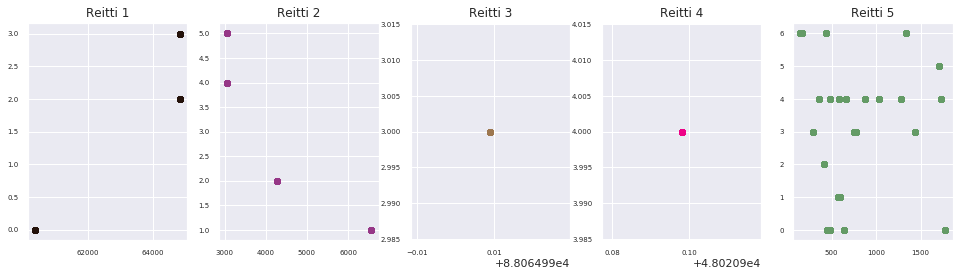

In [81]:
#potato = df_reitit[df_reitit["ajokerta"] == 1][['x', 'y']]
#cluster = AgglomerativeClustering(n_clusters=32, affinity='euclidean', linkage='ward')
#cluster.fit_predict(data)
#kakka = cluster.labels_

#data['label'] = kakka

#plt.figure(figsize=(10, 7))
#plt.title([x for x in potato.columns])
#plt.scatter(potato.iloc[:,0], potato.iloc[:,1], c=cluster.labels_, cmap='rainbow', label=)
ajot = data["predicted"].unique()
ajot_len = max(data["predicted"].unique())

print("Ajokerrat: ",ajot_len)
if ajot_len > 10:
    plt.figure(figsize=(20,(ajot_len/2))) # specifying the overall picture size
elif ajot_len < 10:
    plt.figure(figsize=(20,ajot_len))


for i in ajot:
    plt.subplot((ajot_len/5)+1,6,i+1)
    plt.scatter(data[data["predicted"] == i]['kesto'], data[data["predicted"] == i]['dayofweek'], color=np.random.random(3))
    #sns.lmplot(data=data, x='x', y='y', hue='label', fit_reg=False, legend=True, legend_out=True)
    plt.title(f"Reitti {i+1}")
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)
plt.show()

Ajokerrat:  32


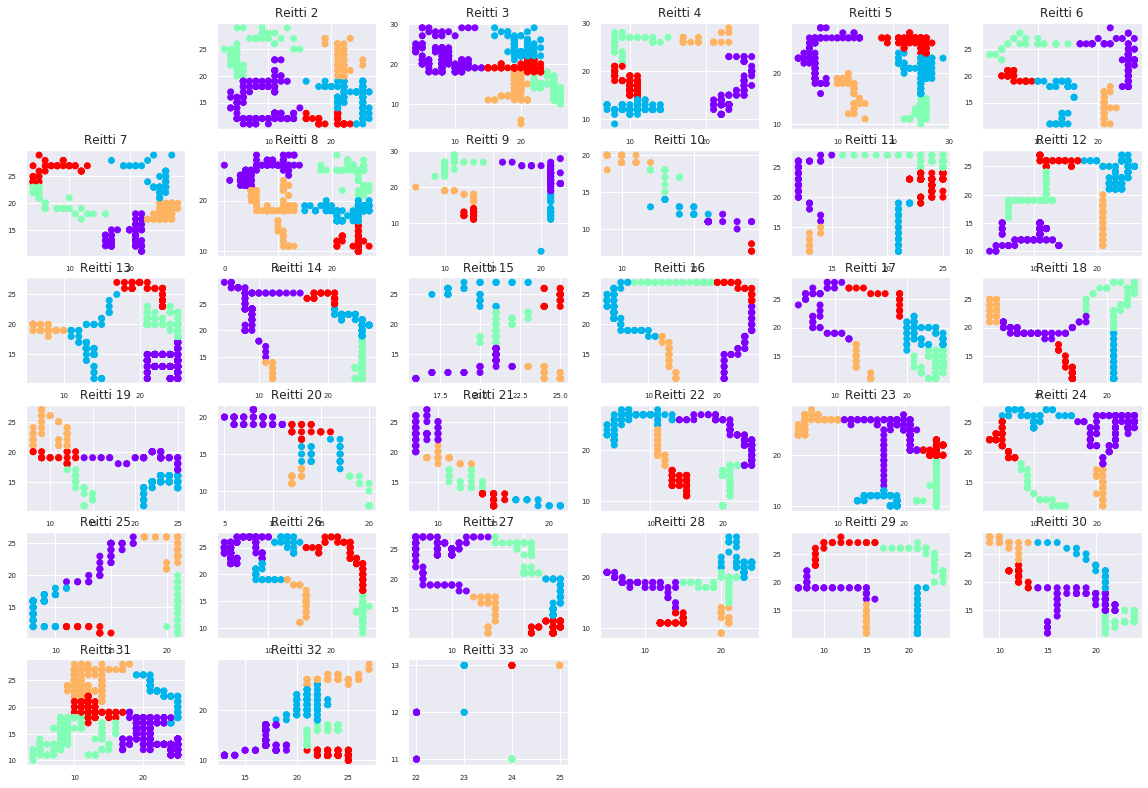

In [134]:
import matplotlib.colors as pltc
from random import sample
import matplotlib.animation as animation

def draw_cluster(df):
    ajot = df["ajokerta"].unique()
    ajot_len = max(df["ajokerta"].unique())

    print("Ajokerrat: ",ajot_len)
    if ajot_len > 10:
        plt.figure(figsize=(20,(ajot_len/2))) # specifying the overall picture size
    elif ajot_len < 10:
        plt.figure(figsize=(20,ajot_len))
        
    #cluster.fit_predict(df)
    #plt.figure(figsize=(10, 7))
    #plt.title("Agglomerative Clustering")
    #plt.scatter(df.iloc[:,0], df.iloc[:,1], c=cluster.labels_, cmap='rainbow')


    for i in ajot:
        df_temp = df[df["ajokerta"] == i][['x', 'y']]
        cluster.fit_predict(df_temp)
        plt.subplot((ajot_len/5)+1,6,i+1)
        plt.scatter(df_temp.iloc[:,0], df_temp.iloc[:,1], c=cluster.labels_, cmap='rainbow')
        #plt.plot(df[df["ajokerta"] == i]['x'], df[df["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
        #plt.scatter(in_x, in_y, color='darkorange', marker='s', s=2)
        #plt.scatter(out_x, out_y, color='green', marker='s', s=2)
        plt.title(f"Reitti {i+1}")
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        #plt.xlim(0, 40)
        #plt.ylim=(0, 40)
        #plt.axis('off')

    plt.show()
    
draw_cluster(df_reitit)

---

# General-use classifier

In [19]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_gaussian_quantiles

## For voting

In [2]:
# get a voting ensemble of models
def get_voting():
	# define the base models
	models = list()
	models.append(('knn1', KNeighborsClassifier(n_neighbors=1)))
	models.append(('knn3', KNeighborsClassifier(n_neighbors=3)))
	models.append(('knn5', KNeighborsClassifier(n_neighbors=5)))
	models.append(('knn7', KNeighborsClassifier(n_neighbors=7)))
	models.append(('knn9', KNeighborsClassifier(n_neighbors=9)))
	# define the voting ensemble
	ensemble = VotingClassifier(estimators=models, voting='hard')
	return ensemble
 
# get a list of models to evaluate
def get_models_voting():
	models = dict()
	models['knn1'] = KNeighborsClassifier(n_neighbors=1)
	models['knn3'] = KNeighborsClassifier(n_neighbors=3)
	models['knn5'] = KNeighborsClassifier(n_neighbors=5)
	models['knn7'] = KNeighborsClassifier(n_neighbors=7)
	models['knn9'] = KNeighborsClassifier(n_neighbors=9)
	models['hard_voting'] = get_voting()
	return models

## For stacking

In [3]:
# get a stacking ensemble of models
def get_stacking():
	# define the base models
	level0 = list()
	level0.append(('lr', LogisticRegression()))
	level0.append(('knn', KNeighborsClassifier()))
	level0.append(('cart', DecisionTreeClassifier()))
	level0.append(('svm', SVC()))
	level0.append(('bayes', GaussianNB()))
	# define meta learner model
	level1 = LogisticRegression()
	# define the stacking ensemble
	model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
	return model

# get a list of models to evaluate
def get_models_stacking():
	models = dict()
	models['lr'] = LogisticRegression()
	models['knn'] = KNeighborsClassifier()
	models['cart'] = DecisionTreeClassifier()
	models['svm'] = SVC()
	models['bayes'] = GaussianNB()
	models['stacking'] = get_stacking()
	return models

In [77]:
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import MeanShift
from sklearn.cluster import SpectralClustering
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import OPTICS
from sklearn.cluster import Birch


# get a stacking ensemble of models
def get_clustering():
    # define the base models
    level0 = list()
    level0.append(('KMeans', KMeans()))
    level0.append(('AffProp', AffinityPropagation()))
    level0.append(('MeanS', MeanShift()))
    level0.append(('Spectral', SpectralClustering()))
    level0.append(('Agglo', AgglomerativeClustering()))
    level0.append(('DBSCAN', DBSCAN()))
    level0.append(('OPTICS', OPTICS()))
    level0.append(('Birch', Birch()))
    # define meta learner model
    #level1 = LogisticRegression()
    # define the stacking ensemble
    #model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    model = VotingClassifier(estimators=models, voting='hard')
    return model


# get a list of models to evaluate
def get_models_clustering():
    models = dict()
    models['KMeans'] = KMeans()
    models['AffProp'] = AffinityPropagation()
    models['MeanS'] = MeanShift()
    models['Spectral'] = SpectralClustering()
    models['Agglo'] = AgglomerativeClustering()
    models['DBSCAN'] = DBSCAN()
    models['OPTICS'] = OPTICS()
    models['Birch'] = Birch()
    models['clustering'] = get_clustering()
    return models

## Model evaluation

In [4]:
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores

## Boxplot of model performance

Boxplot to show the distribution of model error scores

In [52]:
X_train = df_reitit.iloc[:,3:]#df_reitit[['x', 'y']]
y_train = df_reitit['ajokerta']#df_reitit[['ajokerta']]
X_train

,x,y,grid_id,kesto,dayofweek,current_hour
0,22,11,352,64858.412,2,8
1,22,11,352,64858.412,2,8
2,22,11,352,64858.412,2,8
3,26,12,386,64858.412,2,8
4,25,12,385,64858.412,2,8
...,...,...,...,...,...,...
9995,25,13,415,1333.999,6,4
9996,25,13,415,1333.999,6,4
9997,25,13,415,1333.999,6,4
9998,25,13,415,1333.999,6,4


>knn1 0.997 (0.002)
>knn3 0.992 (0.003)
>knn5 0.984 (0.005)
>knn7 0.976 (0.005)
>knn9 0.968 (0.006)
>hard_voting 0.985 (0.004)


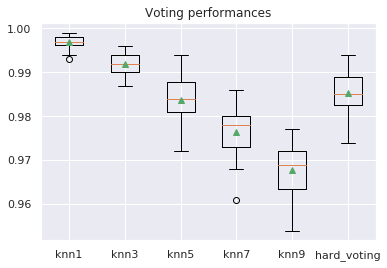

In [53]:
import matplotlib.pyplot as plt

# get the models to evaluate
models = get_models_voting()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title("Voting performances")
plt.show()

>lr 0.185 (0.013)
>knn 0.984 (0.005)
>cart 1.000 (0.000)
>svm 0.338 (0.002)
>bayes 1.000 (0.000)
>stacking 0.519 (0.042)


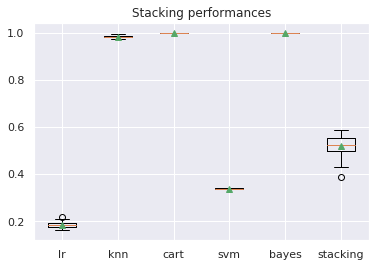

In [54]:
import matplotlib.pyplot as plt

# get the models to evaluate
models = get_models_stacking()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title("Stacking performances")
plt.show()

In [ ]:
# get the models to evaluate
models = get_models_clustering()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.title("Clustering performances")
plt.show()

>KMeans 0.027 (0.029)
>AffProp 0.000 (0.000)
>MeanS 0.037 (0.000)


NameError: name 'x' is not defined

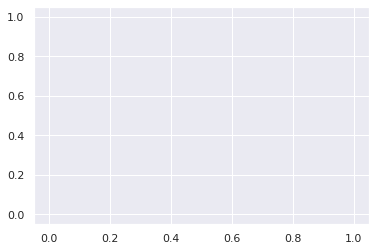

In [96]:
%matplotlib inline



#Linestyle	Description
#'-' or 'solid'	solid line
#'--' or 'dashed'	dashed line
#'-.' or 'dashdot'	dash-dotted line
#':' or 'dotted'	dotted line
#'None' or ' ' or ''	draw nothing

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Suositus 1 node ja esim 1 päivän plot
#x = df_reitit[df_reitit["ajokerta"] == 3]['x']
#y = df_reitit[df_reitit["ajokerta"] == 3]['y']

fig, ax = plt.subplots()
#ax.set_xlim((0, 100))
#ax.set_ylim((0, 100))
line, = ax.plot([], [], marker="o", markersize=3, color='black', markerfacecolor='deeppink')
#plt.scatter(x, y, c=t, cmap='jet')

def init():
    line.set_data([], [])
    return (line,)

def animate(i):
    x = df_reitit[df_reitit["ajokerta"] == 7]['x']
    y = df_reitit[df_reitit["ajokerta"] == 7]['y']
    line.axes.axis([0, 50, 0, 50])
    line.set_data(x[:i], y[:i])
    #line.axes.axis([-2000, 6000, -2000, 5000])
    return (line,)

ani = animation.FuncAnimation(fig, animate, init_func=init, frames=len(x),
                              interval=20, blit=True)
#plt.show()
ani.save('reitti.gif', writer='pillow', fps=60)
ani

# Lasketaan reittien matka gridissä

In [34]:
df_reitit[df_reitit["ajokerta"] == 1]['distance_grid']
df_reitit.groupby(["ajokerta"])["distance_grid"].sum()

ajokerta
1     210
2     350
3     103
4     462
5     161
     ... 
64    104
66     89
67    132
68    135
69     93
Name: distance_grid, Length: 65, dtype: int64

# Lasketaan reittien nopeuden keskiarvo

In [35]:
df_reitit.groupby(["ajokerta"])["velocity_kmh"].mean()

ajokerta
1     1.137495
2     0.803736
3     1.026219
4     1.224285
5     0.925309
        ...   
64    0.996895
66    1.150145
67    1.060939
68    1.233059
69    1.037129
Name: velocity_kmh, Length: 65, dtype: float64

Ajokerrat:  69


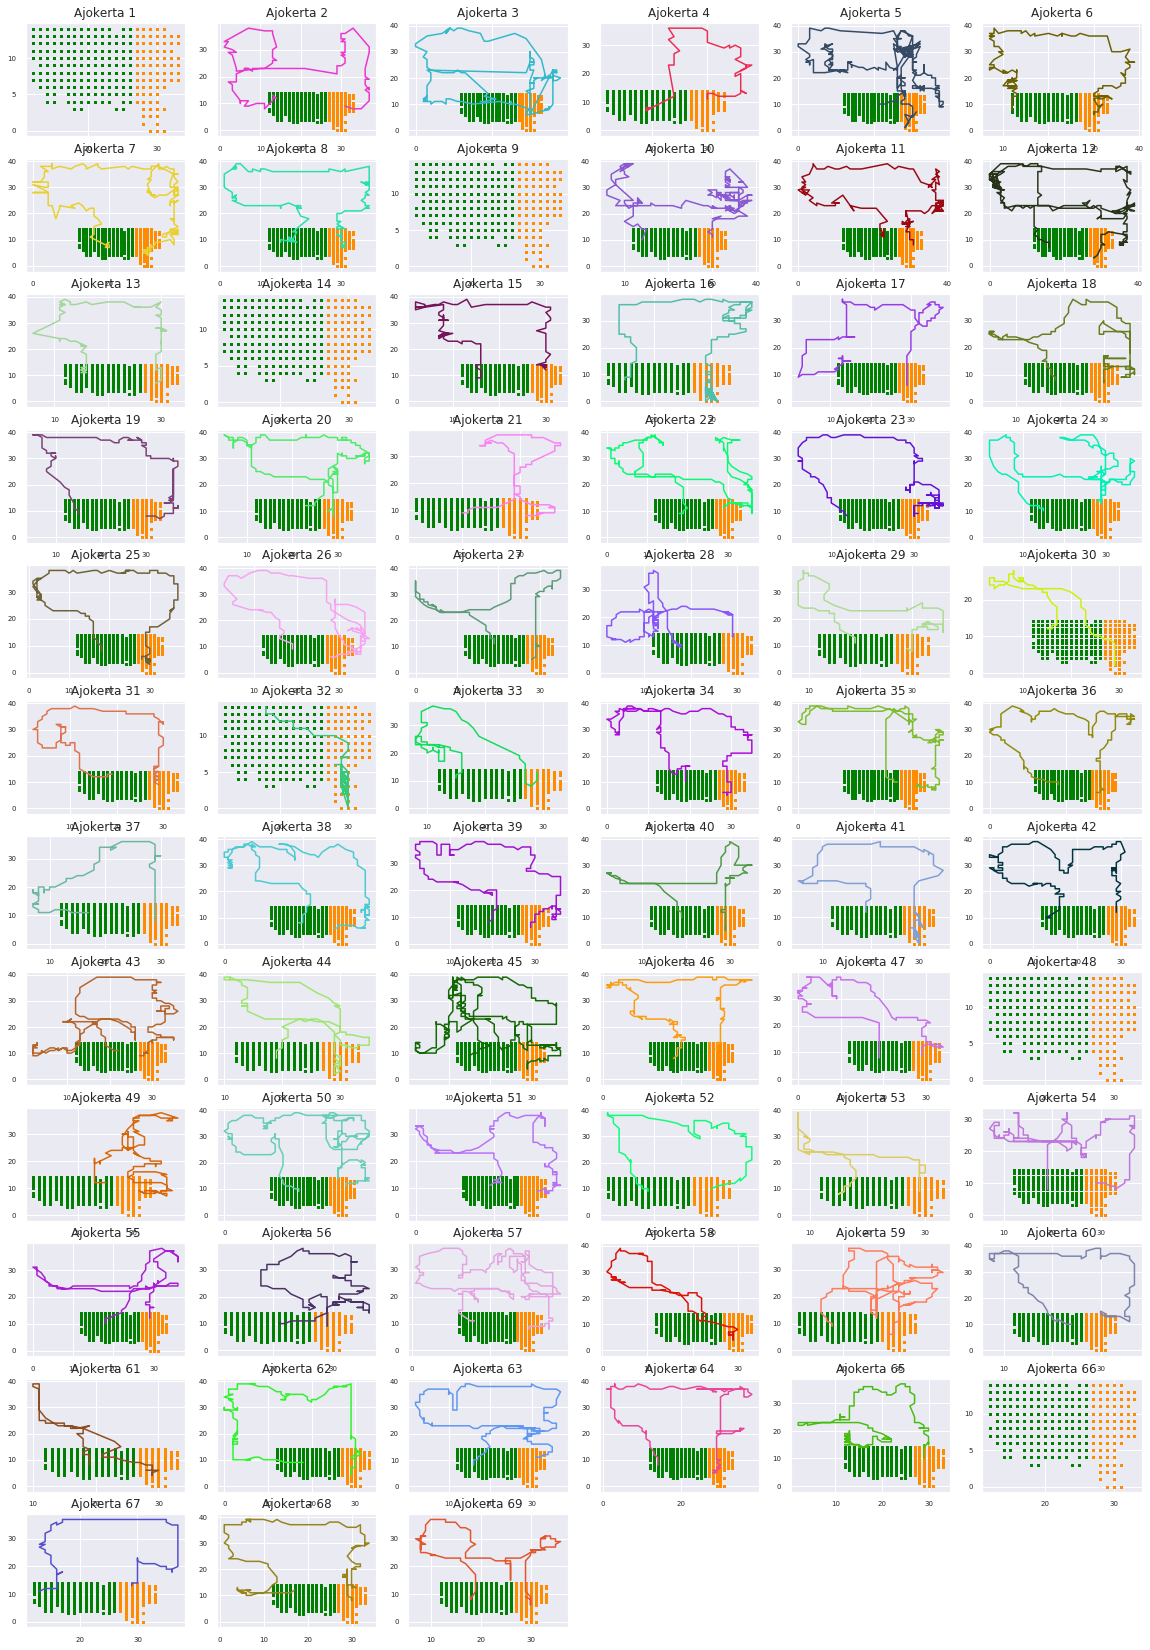

CPU times: user 1min, sys: 3.47 s, total: 1min 4s
Wall time: 21.8 s


In [110]:
%%time

from random import sample
import matplotlib.animation as animation

def draw_route_grid(df):
    ajot = df["ajokerta"].unique()
    ajot_len = max(df["ajokerta"].unique())

    #c = cm.flag(np.linspace(0, 1, ajot_len))

    print("Ajokerrat: ",ajot_len)
    if ajot_len > 10:
        plt.figure(figsize=(20,(ajot_len/2))) # specifying the overall picture size
    elif ajot_len < 10:
        plt.figure(figsize=(20,ajot_len))


    for i in range(ajot_len):
        
        plt.subplot(10,6,i+1)
        plt.plot(df[df["ajokerta"] == i]['x'], df[df["ajokerta"] == i]['y'], color=np.random.random(3))#np.random.random(3)
        plt.scatter(in_x, in_y, color='darkorange', marker='s', s=2)
        plt.scatter(out_x, out_y, color='green', marker='s', s=2)
        plt.title(f"Ajokerta {i+1}")
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        #plt.xlim(0, 40)
        #plt.ylim=(0, 40)
        #plt.axis('off')

    plt.show()

draw_route_grid(df_reitit)

In [50]:
df_reitit

,ajokerta,node_id,timestamp,x,y,grid_id,velocity_kmh,distance_grid,kesto,color
0,1,1,2020-06-24 15:20:14.482,31,9,391,0.575621,0,00:04:45.618000,0
1,1,1,2020-06-24 15:20:15.659,33,8,353,1.392523,2,00:04:45.618000,1
2,1,1,2020-06-24 15:20:15.837,33,8,353,0.882022,0,00:04:45.618000,2
3,1,1,2020-06-24 15:20:17.590,35,8,355,0.928694,2,00:04:45.618000,3
4,1,1,2020-06-24 15:20:21.982,37,11,477,0.760018,5,00:04:45.618000,4
...,...,...,...,...,...,...,...,...,...,...
95,69,1,2020-07-07 16:27:53.793,15,11,455,0.044200,0,00:03:20.998000,21629
96,69,1,2020-07-07 16:27:59.793,15,10,415,0.075000,0,00:03:20.998000,21630
97,69,1,2020-07-07 16:27:59.795,15,10,415,2.890000,0,00:03:20.998000,21631
98,69,1,2020-07-07 16:28:01.793,15,9,375,0.412412,1,00:03:20.998000,21632


In [67]:
import seaborn as sns
sns.set();
def plot_unique_routes(df, grid_size, in_x, in_y, out_x, out_y):
    ajot = df["ajokerta"].unique()
    ajot_len = max(df["ajokerta"].unique())

    print("Ajokerrat: ",ajot_len+1)
    if ajot_len > 10:
        plt.figure(figsize=(20,(ajot_len/2))) # specifying the overall picture size
    elif ajot_len < 10:
        plt.figure(figsize=(20,ajot_len))


    for i in ajot:
        plt.subplot((ajot_len/5)+1,6,i+1)
        facet = sns.scatterplot(x="x", y="y", data=df[df["ajokerta"] == i],  hue="color", size=2, legend=None)
        plt.scatter(in_x, in_y, color='darkorange', marker='s', s=2)
        plt.scatter(out_x, out_y, color='green', marker='s', s=2)
        plt.title(f"Ajokerta {i+1}")
        plt.xticks(fontsize=7)
        plt.yticks(fontsize=7)
        plt.xlim(0, 40)
        plt.ylim=(0, 40)
        #plt.axis('off')

    plt.show()

Ajokerrat:  69


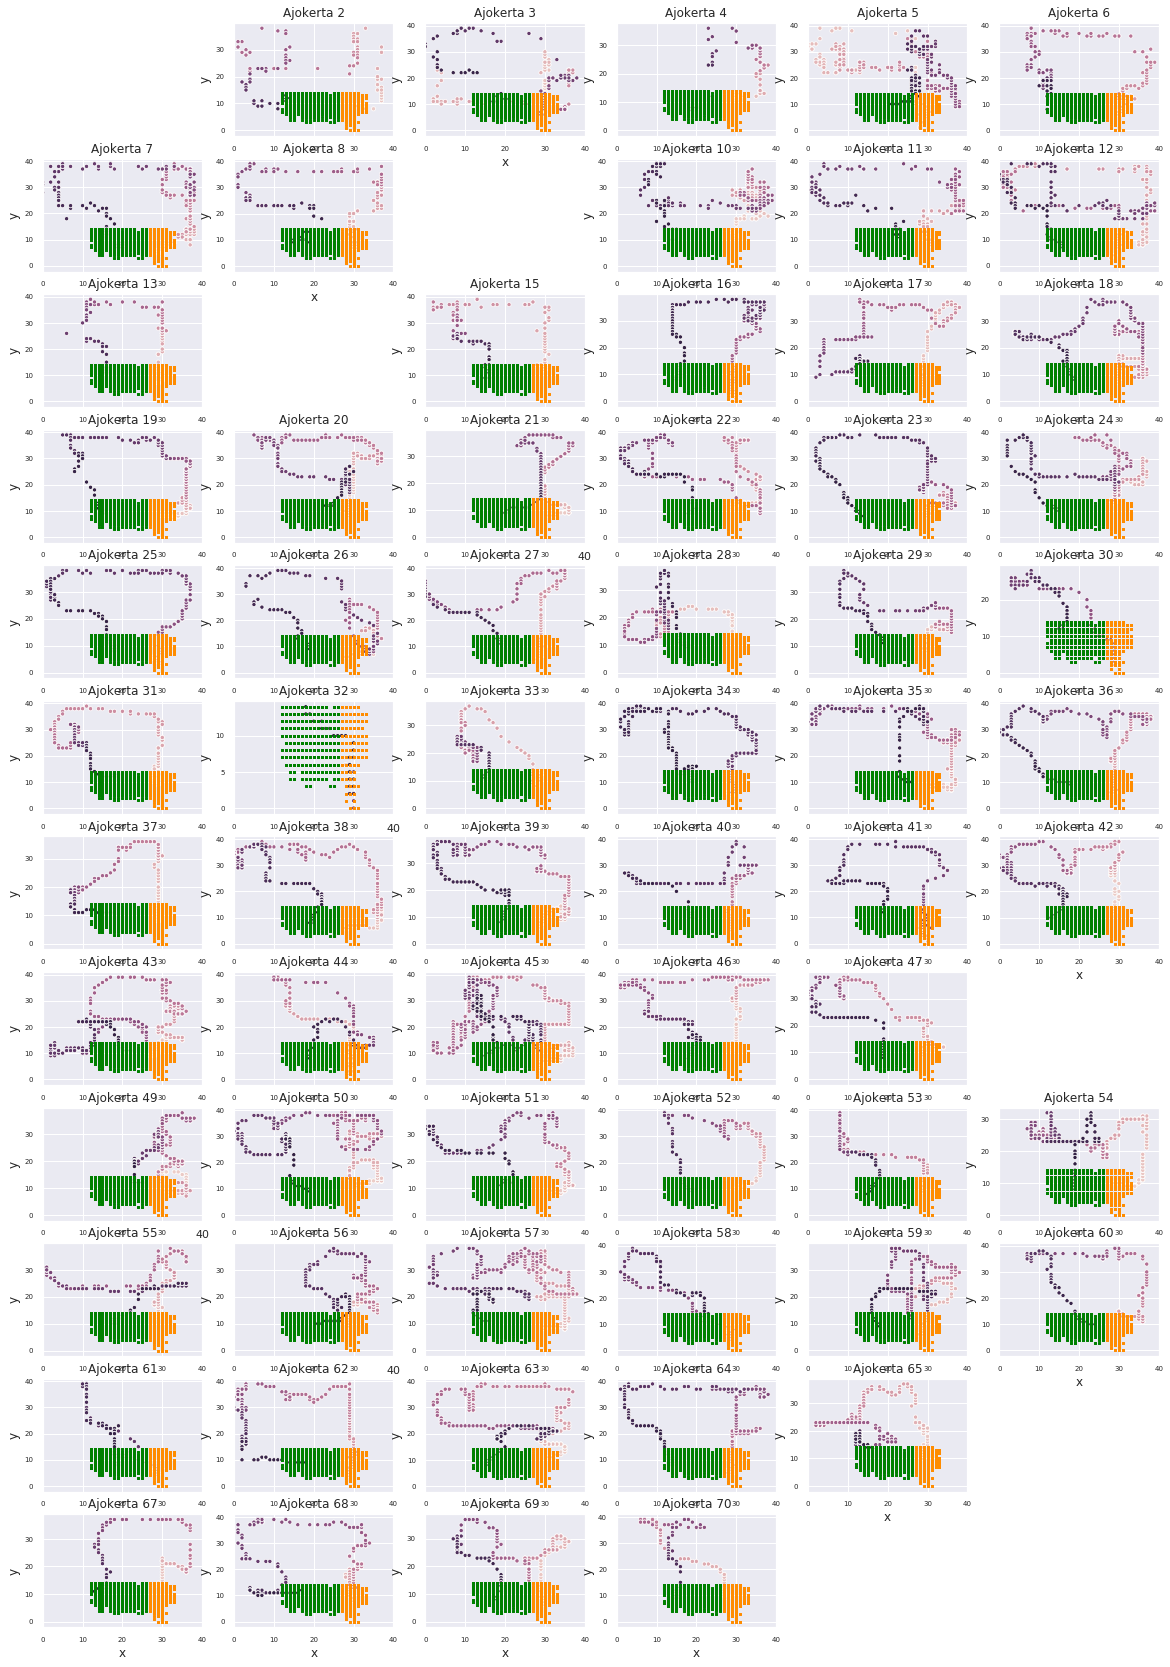

CPU times: user 1min 2s, sys: 3.96 s, total: 1min 6s
Wall time: 25.5 s


In [68]:
%%time
# Plottaa jokaisen kauppareissut erikseen.
plot_unique_routes(df_reitit, grid_size, in_x, in_y, out_x, out_y)
# Ensimmäisissä on aika paljon häiriötä